In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

Tutorial: https://github.com/ppsp-team/PyNM/blob/master/tutorials/2-multivariate_confounds.ipynb

# Multivariate Confounds
In this tutorial we'll look at using the Gaussian Process (GP) model to overcome two of the limitations of the LOESS & Centiles models we encountered in the previous tutorial:

Handling missing data
Modeling datasets with multivariate confounds


## Gaussian Processes
Gaussian Processes (GPs) are a probabilistic approach to regression that allow us to have a Confidence Interval (CI) for the prediction.

From Kilian Weinberger's Cornell lecture:

    Definition: A GP is a (potentially infinite) collection of random variables (RVs) such that the joint distribution of every finite subset of RVs is multivariate Gaussian.

A full discussion is beyond the scope of this tutorial, but we can get by with some key points:

- GPs are a form of Bayesian inference and a prior needs to be specified. The prior mean is taken to be 0, and the prior covariance is specified using kernels.
- The kernel used in the PyNM implementation is composed of the Matern kernel plus a constant kernel and a white noise kernel.
- Data must meet the model assumptions (notably homoskedasticity & gaussian noise) for prediction & CIs to be reliable.
- GPs don't scale well to large datasets (cubic complexity in data size).
    - Recommended cutoff for dataset size with PyNM is 2000 subjects


### Recap on Kernels

In the context of Gaussian Processes (GPs), a kernel is a function that defines the covariance between any two points in the input space. It essentially determines how similar or related two inputs are in terms of their output values in the model. The kernel function plays a central role in specifyng the prior covariance of the Gaussian Process.

### Key points about kernels in GPs:

1. Covariance Structure:
    - A kernel defines the covariance matrix (or covariance function) that expresses the relationship between any pair of input points. The strength of the relationship between points affects the smoothness, continuity, and behaviour of the GP's prediction.
    - The covariance matrix is used to represent uncertainty in the data and make predictions with corresponding confidence intervals.

2. Form of the Kernels:
    - The kernel function takes two input points, $x$ and $x'$, and outputs a value (a covariance) that tells how much the outputs corresponding to these points are expected to covary or be related
    - In this case, the **Matern kernel, constant kernel and white noise kernel** are combined to form the overall covariance function.

    For example: 

    1. One-dimensional Input: Age
        Modeling a relationship involving age as the input feature.

        $x$ = 30
        <br>
        $x'$ = 40

        The Matern kernel would compute the covariance between these two ages, which depends on the distance between them (i.e.,∣30−40∣=10) and the smoothness/length scale parameters of the kernel.

    2. Multi-dimensional Input: Age and IQ
        Modeling a relationship involving age and IQ as input features.
 

        $x$ = [30, 110]
        <br>
        $x'$ = [40, 120]

        Here, $x$ and $x'$ are 2-dimensional feature vectors. The Matern kernel will compute the covariance based on the distance between the two feature vectors (e.g., Euclidean distance) and will factor in both the age and IQ differences.


3. Types of Kernels in the Example:

    - Matern kernel: This is a popular kernel for GPs that controls the smoothness of the function. It's more flexible than the commonly used squared exponential (RBF) kernel because it can model rougher or smoother functions depending on the parameters.
    - Constant kernel: This kernel adds a constant value to the covariance, allowing for the possibility that all points have some shared baseline correlation.
    - White noise kernel: Adds noise (random fluctuation) to the data, modeling observation noise or error, often used to account for measurement error or inherent randomness in the observations.

4. Role of Kernels in Bayesian Inference:

- In GPs, you specify a prior distribution over the possible functions that could explain the data, and this prior is governed by the kernel. The prior assumes that the mean function is 0, but the covariance is shaped by the kernel.
- After observing the data, the GP updates the prior using the data to form a posterior distribution, which makes predictions with uncertainty estimates (confidence intervals).

5. Homoskedasticity & Gaussian Noise Assumptions:

- The kernel's role assumes certain statistical properties, like homoskedasticity (constant variance across the data) and Gaussian noise (the error or noise in the data follows a normal distribution), so the predictions and confidence intervals remain reliable under these assumptions.



## Example 1

First we'll revisit the dataset from the previous tutorial to illustrate how the GP model deals with missing data compared to the LOESS & Centiles models.

Here we are using a dataset with:

- A single explanatory variable (age)
- Homoskedastic variance across the explanatory variable
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [6]:
# Define functions to simulate data

# Generate n_subs samples drawn uniformly from the interval low, high
# 'full' refers to sampling from one normal distribution, while sampling != 'full' generates form two normal distributions
def sample_x(low=1, high=100, n_subs=1000, sampling = 'full'):
    if sampling == 'full':
        x = np.random.uniform(low = low, high = high, size = n_subs)
    else:

        # The first half of n_subs comes from a normal distribution with a mean of 20 and a sd of 10
        # The second half comes from a normal distribution with a mean of 80 and a sd of 10
        # The two sets are concatenates into one array     
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)), np.random.normal(80,10,size=int(n_subs/2))])
        
        # The final array is filtered to only keep values between low and high
        x = x[(x<high) & (x>low)]
    return x


# Define basic logarithmic function
def f(x):

    # f(x)=2⋅ln(x)+ϵ 
    # Formula of the ln(x) scaled by 2, plus a random noise from a normal distribution with mean 0 and sd 1
    return 2*np.log(x)+np.random.randn()


# Define function to generate dataset
def dataset(seed=10, sampling='full'):
   
    # Set seed of random number, ensures reproducibility, default seed is set at 10
    np.random.seed(seed)

    # Generate age parameter based on sample_x funtion defined earlier
    # Sort the ages in ascending order to help visualisation/analysis
    x = np.sort(sample_x(sampling=sampling))

    # Simulate control and proband status, by having two binary arrays with different probabilities of probands/controls
    # 75% of the data points (status_1) have a 20% probability of being assigned 1 (first 75% of ages have a 20% chance of being Proband)
    # 25% of the data points have a 7% probability of being assigned a 1 (Next 25% of ages have a 7% of being a Proband)
    status_1 = np.random.binomial(1,0.2,size=(int(0.75*x.shape[0]))) #np.random.binomial(n: num of trials, p: prob. of success (0 or 1), size = output shape)
    status_2 = np.random.binomial(1,0.07, size=(x.shape[0]-status_1.shape[0]))
    status = np.concatenate([status_1,status_2])

    # Simulate score parameter

    #Create an empty array of length x.shape[0]
    score = np.zeros(x.shape[0])

    # Loop over each element in the array and calculates a score for the corresponding element x[i]
    for i in range(x.shape[0]):

        # Apply a function f(x) to the i-th element of x
        s = f(x[i])

        # Random offset only for probands not for controls
        # Since status = 1 for probands, a random value drawn from a normal distribution with a mean of 0.7 and sd of 1 is added to the score
        s = s + status[i]*np.random.normal(0.7,1)

        # Assign the calculated score s to the i-th position in the empty score array
        score[i] = s
    
    # Transpose switches the rows and columns so that age, status and score become column names instead of row names
    return pd.DataFrame([x, status, score], index=['age', 'status', 'score']).transpose() 


<Axes: xlabel='age', ylabel='score'>

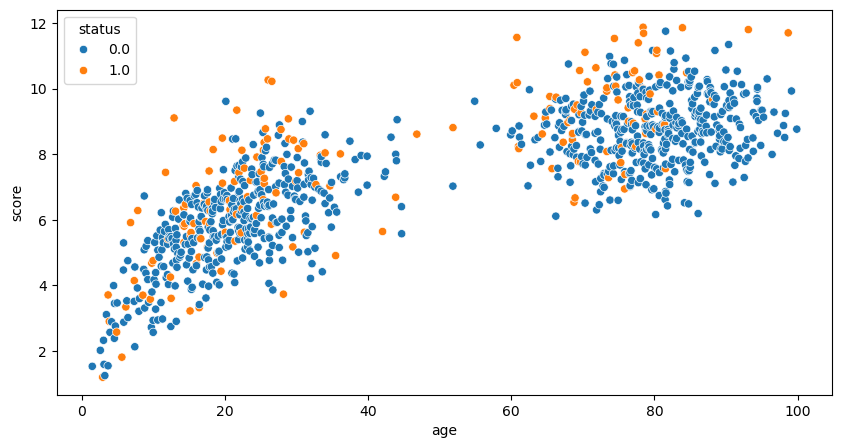

In [7]:
# Create a dataset with a gap
df_gap = dataset(sampling='gap')

# Visualise data
# PROB = 1/CON = 0
plt.figure(figsize=(10,5))
sns.scatterplot(x='age', y='score', hue='status', data=df_gap)

### Fit GP model with single confound on missing data

In [8]:
# Initialise PyNM object with data and confound and bin parameters
m_gap = PyNM(df_gap, 'score', 'status', ['age'], bin_spacing=1, bin_width=3)

# Run models
m_gap.loess_normative_model()
m_gap.centiles_normative_model()
m_gap.gp_normative_model()

Models will be fit on full set of controls.


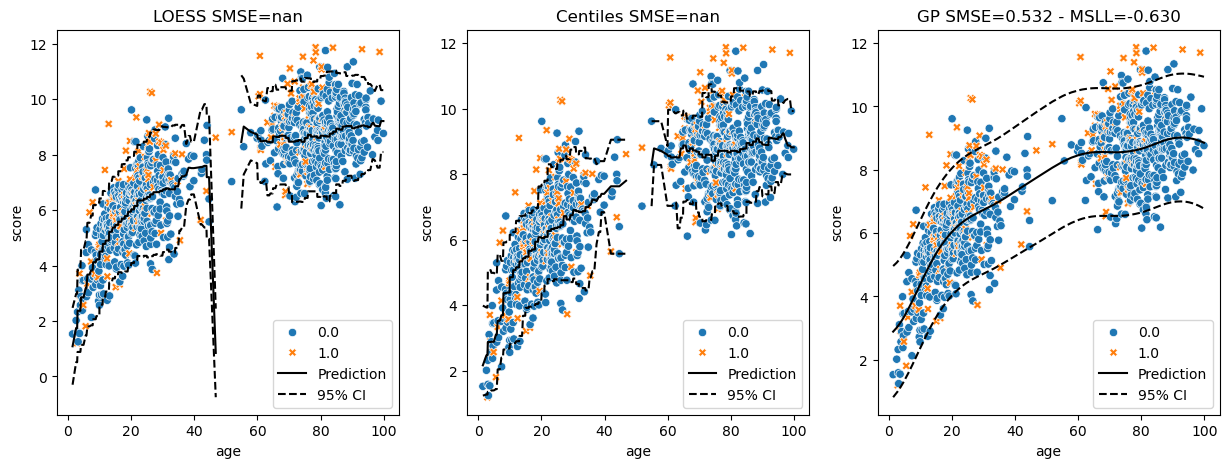

In [9]:
# Plot the data, model prediction and 95% confidence interval
m_gap.plot()

## Interpretation

We can see in the plot below that the GP model makes predictions smoothly in the region with missing data, with a slight decrease in confidence (widening of the CI). This is clearly a huge improvement over the LOESS & Centiles models.

### What is the Mean Standardised Log Loss (MSLL) ?

The Gaussian process also has a metric called the Mean Standardised Log Loss (MSLL) used to evaluate the quality of the model. This is done by computing a difference between two log losses measures :

$$
\text{LL} = \frac{1}{N} \sum_{i=1}^{N} \left( \text{Log Loss}_{\text{model}} - \text{Log Loss}_{\text{baseline}} \right)
$$

- The negative log likelihood under the predictive distribution (Gaussian with a mean of $y_{pred}$ and variance of $\sigma$). This term reflects how well the predicted Gaussian distribution fits the true value $y_{true,i}$.

MINUS 

- The negative log likelihood under a trivial (baseline) model that uses the training data's mean $\mu_{train}$ and variance $\sigma^2_{train}$. This term represents a simpler model that assumes the mean and variance of the training data for every prediction.

This difference indicates how much better (or worse) the Gaussian Process model is compared to the baseline model. The mean over all data points gives the final MSLL value.


$$
\text{MSLL} = \frac{1}{N} \sum_{i=1}^{N} \left( \underbrace{\frac{1}{2} \log(2\pi\sigma_i^2) + \frac{(y_{\text{true},i} - y_{\text{pred},i})^2}{2\sigma_i^2}}_{\text{Log loss of the model}} - \underbrace{\frac{1}{2} \log(2\pi\sigma_{\text{train}}^2) + \frac{(y_{\text{true},i} - \mu_{\text{train}})^2}{2\sigma_{\text{train}}^2}}_{\text{Log loss of the baseline model}} \right)
$$


Where:

- $y_{true}$ be the true values of the response variable.
- $y_{pred}$ be the predicted mean values from the Gaussian Process.
- $\sigma$ be the predicted standard deviations (uncertainties) from the Gaussian Process.
- $\mu_{train}$ be the mean of the training data.
- $\sigma_{train}$ be the standard deviation of the training data.


**How to interpret the MSLL?**

First, understand how to interpret Log-loss values:
- **Log-loss close to 0:** the predicted distribution perfectly matches the true data. The log loss will never be 0 due to the nature of the Gaussian distribution, but it will be minimal.
- **Log-loss close to 1:** the predicted distribution matches the true data poorly.

Now, let's look at MSLL:
- **MSLL<0:** means that, on average,the log loss of your prediction model is smaller than the log loss of the baseline model. This suggests that on average across all points, the prediction model does a better job at predicting the data than a baseline model. (NB: it could also mean that your baseline model just does very poor predictions due to its constant mean and variance)

- **MSLL>0:** means that, on average,the log loss of your prediction model is bigger than the log loss of the baseline model. This suggests that on average across all points, the prediction model does a worst job at predicting the data than a baseline model. 

In our case, the third graph shows that the MSLL for the Gaussian Process Normative Model has a negative MSLL, suggesting accurate prediction of the data by the model.

## Example 2

In this example we'll look at a dataset with multivariate confounds (age, sex, and site) in addition to the basic score and group columns. The GP model can take an arbitrary number of confounds, in contrast to the LOESS & Centiles model which take only one. We'll compare the deviance scores from the three model to illustrate the advantage brought by the GP.

Here we are using a dataset with:

- Multiple confounds (explanatory variables) (age, sex & site)
- Homoskedastic variance across the explanatory variable within each site
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution
- A random offset in score for sex pulled from the gaussian distribution
- A random offset in score for site pulled from the gaussian distribution (constant for all subjects from same site)

In [22]:
def g(age, sex, offset, prob = False):
    noise = np.random.normal(0, 0.1)
    if prob:

        # 0.001 * age: This term linearly increases the output based on age.
        # -0.00001 * (age - 50) ** 2: This quadratic term peaks at age 50. 
        # It means that the output decreases as you move away from age 50, 
        # which suggests that 50 might be an optimal age for whatever this function is modeling.
        # - np.random.uniform(0, 0.3) * sex: This line reduces the output by a random amount 
        # (between 0 and 0.3) if sex is 1 (indicating one gender). If sex is 0, this term does 
        # not contribute to the output.

        return 0.001*age-0.00001*(age-50)**2 + .5 + noise - np.random.uniform(0, 0.3) * sex-0.2 * np.random.uniform() + offset
    else:

        # same but without the term: - 0.2 * np.random.uniform(), makes it more stable.
        return 0.001*age-0.00001*(age-50)**2 + 0.5 + noise - np.random.uniform(0, 0.3) * sex + offset
    

def dataset_multivariate(n_sites=5, sample_size=35, seed=650):
    np.random.seed(seed)
    n_sites=n_sites

    # np.random.rand(n_sites): generates an array of shape (n_sites,) containing random floating-point 
    # numbers uniformly distributed between 0 and 1. For example, if n_sites = 5, it could generate 
    # something like [0.1, 0.5, 0.8, 0.3, 0.7]. After multiplication by 50, we would get something like [5, 25, 40, 15, 35].
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data = {'sex_ratio': np.random.rand(n_sites), # generate an array of 5 random float values uniformly distributed between 0 and 1
                                 'prob_ratio': 0.5*np.random.rand(n_sites), # same as above but * 0.5 scales the uniform distribution to probs that range from 0 to 0.5. Will be useful to calculate the score.
                                 'age_min': age_min,
                                 'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int), # add random value between 0 and 50 to minimal age (+ 5 years baseline)
                                 'score_shift': np.random.randn(n_sites)/4, # This generates random values from a standard normal distribution (mean = 0, standard deviation = 1) and divides them by 4. Small spread.
                                 'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)}) # random numbers multiplied by 350 and summed to minimal sample size of 35, everything is turned into an int to get full samples.
    

    participants = []

    # iterate over each row of the sites df, site[0] is the index of the current row, site[1] has the data
    for site in sites.iterrows():
        # inner loop runds for a number of items equal to the sample_size rounded to an integer (number of participants basically)
        for participant in range(int(site[1]['sample_size'])):

            # A binary value (0 or 1) is generated using a binomial distribution. The parameter 1 indicates a single trial, and site[1]['sex_ratio'] 
            # is the probability of success (i.e., the probability that the participant is of one sex). If sex_ratio is 0.6, there's a 60% chance the 
            # participant will be female (1) and a 40% chance they will be male (0).
            sex = np.random.binomial(1, site[1]['sex_ratio'])

            # Same as above but with probability ratio
            prob = np.random.binomial(1, site[1]['prob_ratio'])

            # A continuous value for participant's age is generated uniformly between age_min and age_max for that site
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            
            # The participant's score is computed using the g function defined previously, prob is used as an input
            score = g(age, sex, site[1]['score_shift'],prob=prob)
            
            # The information for each participant is appended in a list
            participants.append([site[0], sex, prob, age, score])
        
        df = pd.DataFrame(participants, columns = ['site', 'sex', 'status', 'age', 'score'])

    return df


In [24]:
# Create a dataset
df = dataset_multivariate()
df.head()

,site,sex,status,age,score
0,0,1,0,65.818713,0.409020
1,0,1,0,68.827045,0.294608
2,0,0,0,61.660016,0.313654
3,0,0,0,66.886592,0.423175
4,0,0,0,55.738248,0.257225


### Visualize data
Here we'll look at the data as we usually do (by PROB/CTR), but we'll also explore the effect of the confounds by looking at the data plotted by site and sex.

We've chosen to simulate a proband effect that causes a lower score, we can see this by eye when comparing the plots by PROB/CTR and by site - but we can expect the models that don't account for site to miss this effect as the site offsets overwhelm the effect.

Text(0.5, 1.0, 'By sex')

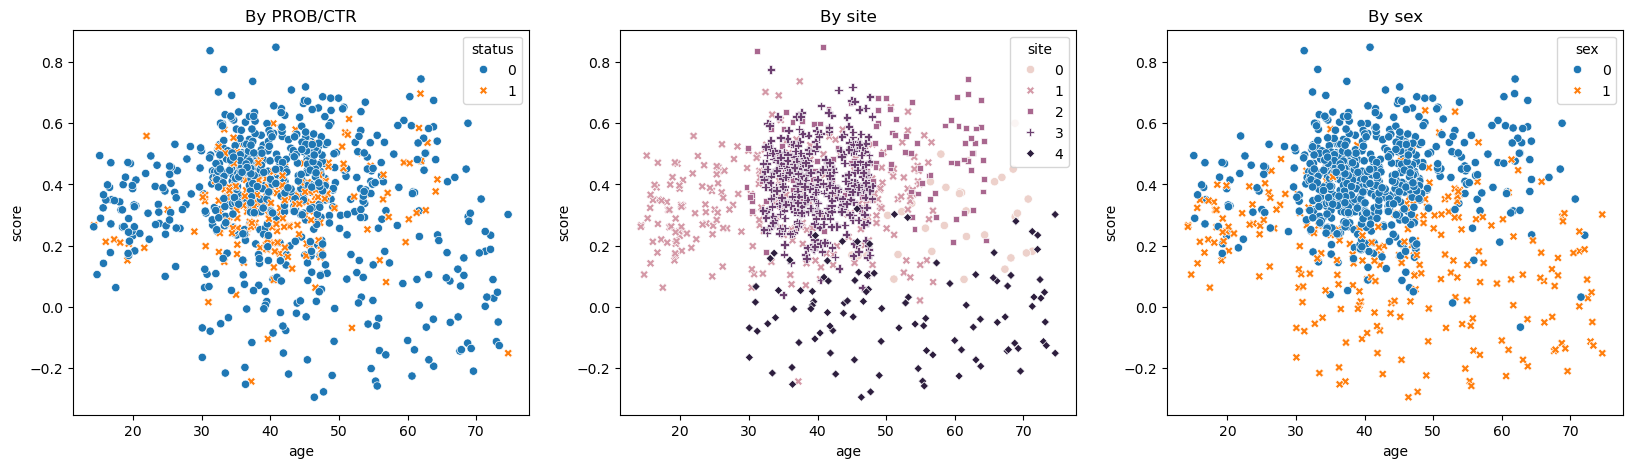

In [27]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.scatterplot(data=df, x='age', y='score', hue='status', style='status',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue = 'site', style='site', ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue = 'sex', style='sex', ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')


In the case of categorical confounds, it is useful to take a look at the distribution of the data within each category using violin plots. Here we can clearly see the offset in score associated with each site and sex. This will serve as a useful point of comparison when we take a look at the deviance scores from our models.

Text(0.5, 1.0, 'By sex')

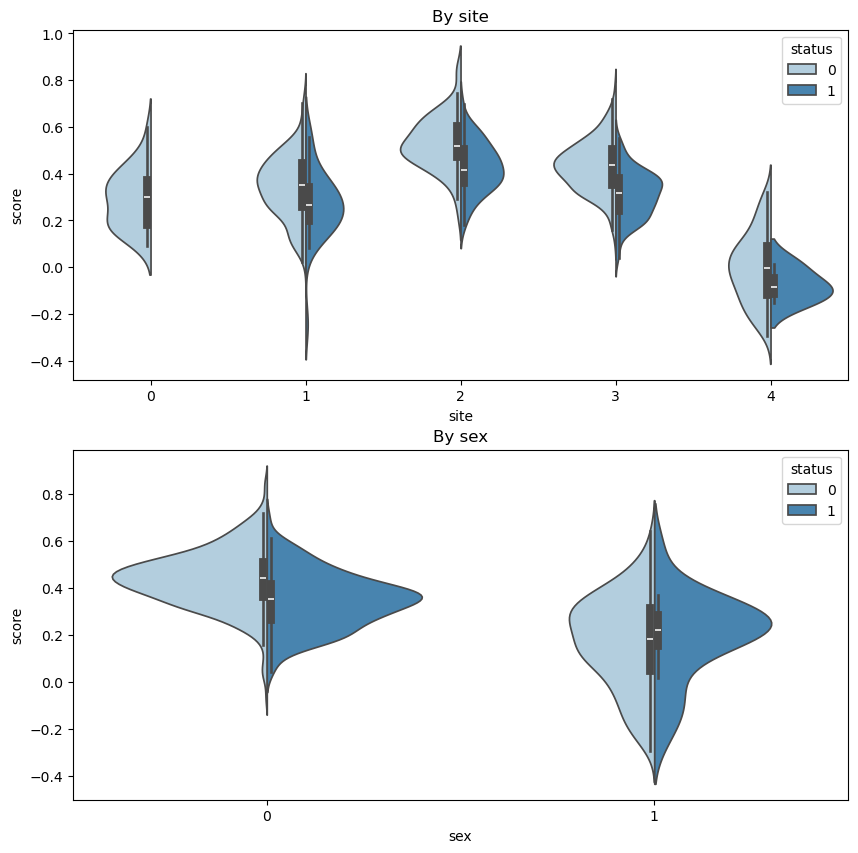

In [32]:
fig,ax = plt.subplots(2,1, figsize=(10,10))

sns.violinplot(x='site', y='score', data=df, split=True, palette='Blues', hue='status', ax=ax[0])
sns.violinplot(x='sex', y='score', data=df, split=True, palette='Blues', hue='status', ax=ax[1])

ax[0].set_title('By site')
ax[1].set_title('By sex')

### Fit GP model with multivariate confounds


In [33]:
# Initialize pynm with data, confounds, & bin parameters
# c is to denote categorical variables
m = PyNM(df,'score','status',['age','c(sex)','c(site)'],
        bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [34]:
# Run models
m.loess_normative_model()
m.centiles_normative_model()
m.gp_normative_model()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


The first obvious characteristic of the GP model is that the plot is a mess. Since it is using more information than is possible to represent in the 2D plot of score vs age it is not simple to visualize, but we can see that it can capture more trends in the data than the LOESS & Centiles models which make a simple prediction in each bin.

In this scenario it is much more informative to look at the plot of the deviance scores for each of the categorical variables. We can see that the GP model corrects beautifully for the site and sex (deviance scores centered about 0), whereas the LOESS & Centiles models are offset.

In the plot of deviance scores against the age confound it's not only clear that the GP corrects well for age, but also that the difference between probands and controls becomes clear when the confounds are well modeled.

-->  the points supposed to be randomly distirbuted for a good model, with no visible pattern right?

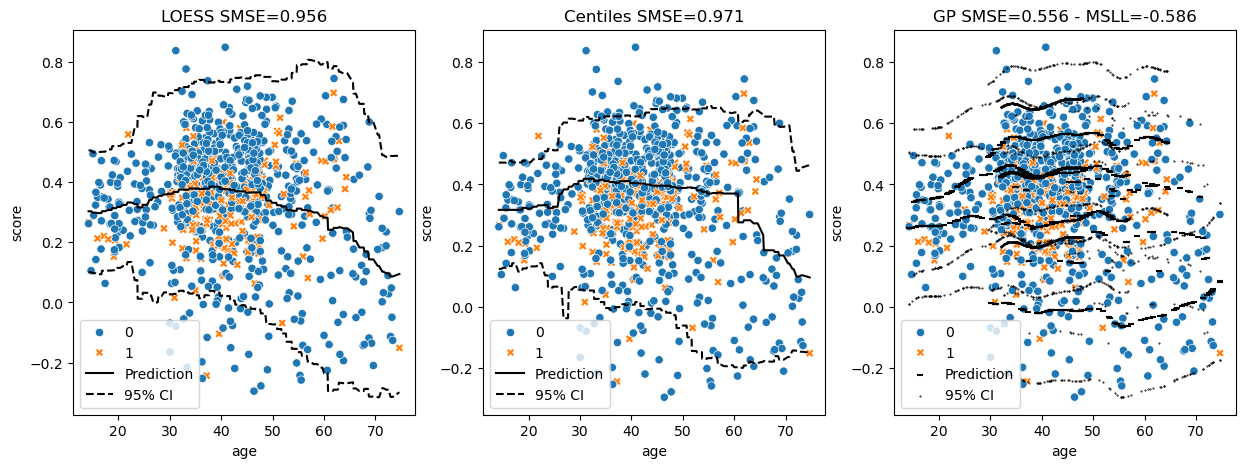

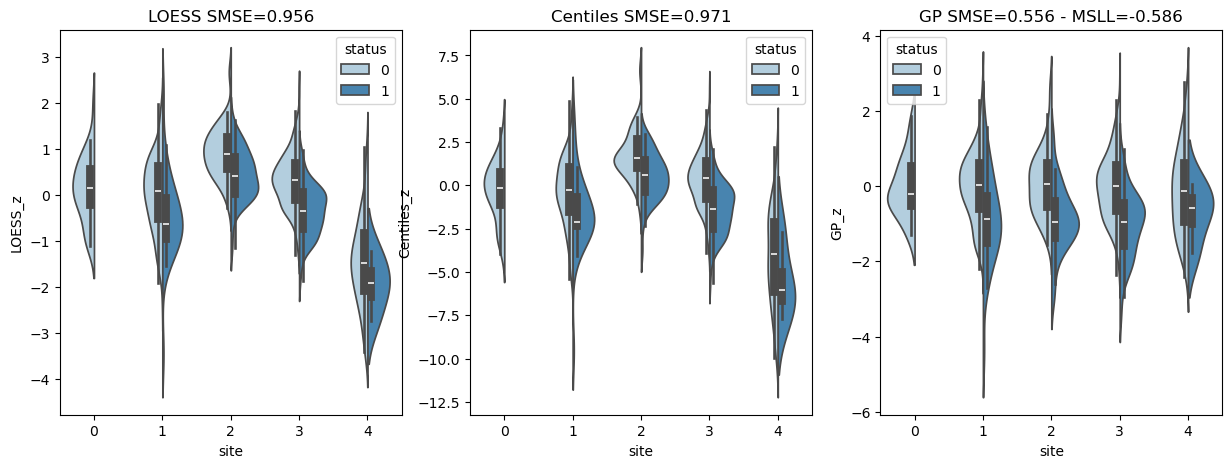

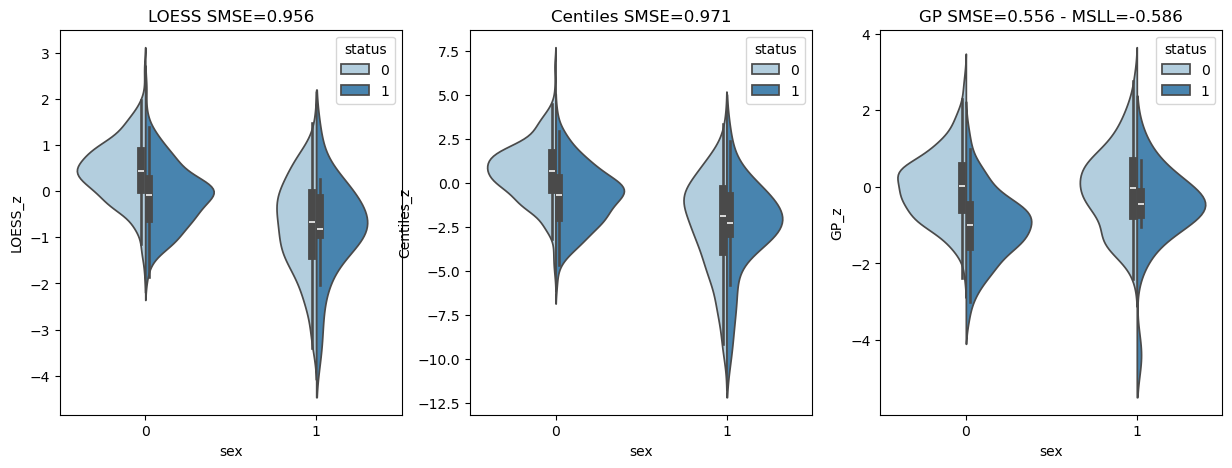

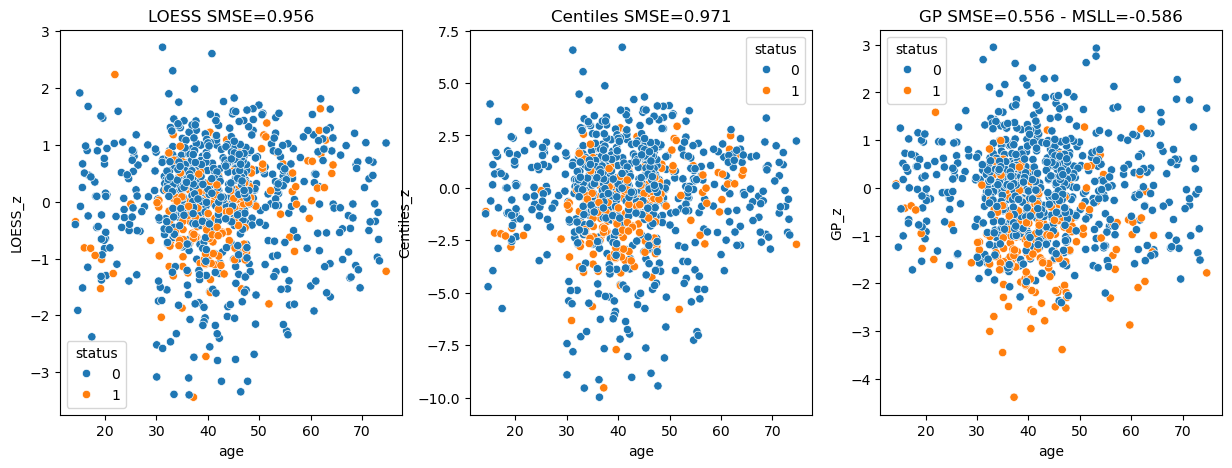

In [35]:

# Plot the data, model prediction, & 95% confidence interval
m.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z(confound='site')
m.plot_z(confound='sex')
m.plot_z(confound='age')

## Example 3

In this example we'll look at a simple dataset that violates the homoskedasticity and gaussian noise assumptions.

Here we are using a dataset with:

- A single explanatory variable (age)
- Heteroskedastic variance across the explanatory variable
- Non-gaussian noise
- A random offset in score for probands pulled from the gaussian distribution


In [36]:
# Define functions

# Create a function to generate a noisy signal that has a sinuisoidal component with heteroscedastic noise (i.e. noise whose variance changes with the input).
def hetero_sin_noise(x):

    # 3*np.sin(0.05*x): computes a sine wave with an amplitude of 3
    # np.sin() takes an angle in radians, 0.05*x scales the input x, resulting in a low-frequency sine wave.
    # np.random.randn() generates a single random sample from a standard normal distribution (mean = 0, standard deviation = 1). 
    # By multiplying this random value by the sinusoidal component, you introduce multiplicative noise.
    # sp.skewnorm.rvs(a=2, size=1): generate a single random value from a skewed normal distribution with a specified shape parameter a=2.
    # The [0] at the end extracts the first (and only) value from the array returned by rvs() since size=1.

    return 3*np.sin(0.05*x)*np.random.randn() + sp.skewnorm.rvs(a=2, size=1)[0]


def dataset_heteroskedastic(low=1, high=100,n_subs=1000, sampling='full', seed=888):
    np.random.seed(seed)
    x = sample_x(low=low, high=high, n_subs=n_subs, sampling=sampling)

    # PROB = 1/CTR = 0
    status = np.random.binomial(1,0.07,size=x.shape[0]) # 7% of subjects are probands

    # Score param
    score = np.zeros(x.shape[0])

    # Loop over each subject in the dataset
    for i in range(x.shape[0]):
        s = 5 + hetero_sin_noise(x[i]) # Score set to 5 + an extra value taken from the hetero_sin_noise function

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1) # add random offset (mean 0.7, sd 1)

        score[i] = s
    
    df = pd.DataFrame([x, score, status], index = ['age', 'score', 'status']).transpose()

    return df



In [37]:
# Create a dataset
df_het = dataset_heteroskedastic()
df_het.head()

,age,score,status
0,86.096500,6.546667,0.0
1,17.292380,4.395376,1.0
2,48.864120,4.275272,0.0
3,92.181699,4.362332,1.0
4,43.427088,6.529171,0.0


### Visualise data

<Axes: xlabel='age', ylabel='score'>

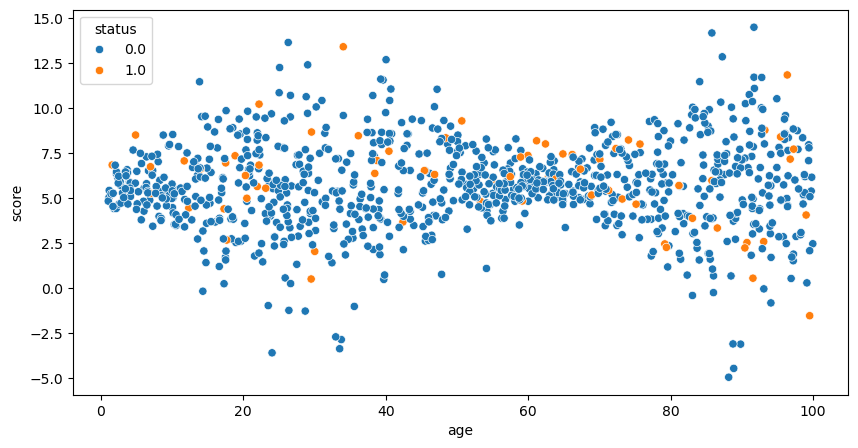

In [39]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age', y='score', hue='status', data=df_het)

### Fit GP model on heteroskedastic data

In [40]:
# Initialize pynm w/ data, confounds, & bin parameters
m_het = PyNM(df_het,'score', 'status', ['age'], bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [43]:
# Run models

m_het.loess_normative_model()
m_het.centiles_normative_model()
m_het.gp_normative_model()



/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:513: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:519: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")


First, we get warnings from the GP model that the residuals are not Gaussian and heteroskedastic. These warnings are meant to be a safeguard, but they shouldn't be totally relied upon as they are implementing simple tests that don't apply in every scenario.

We can see that the GP model fit is nonsensical, but there are two things happening at the same time. 

1. The first is that the model is overfitting the training data, we'll use this as an opportunity to explore the length_scale and length_scale_bounds parameters.

2. The second will be adressed in further tutorials (CI are not assessed properly)

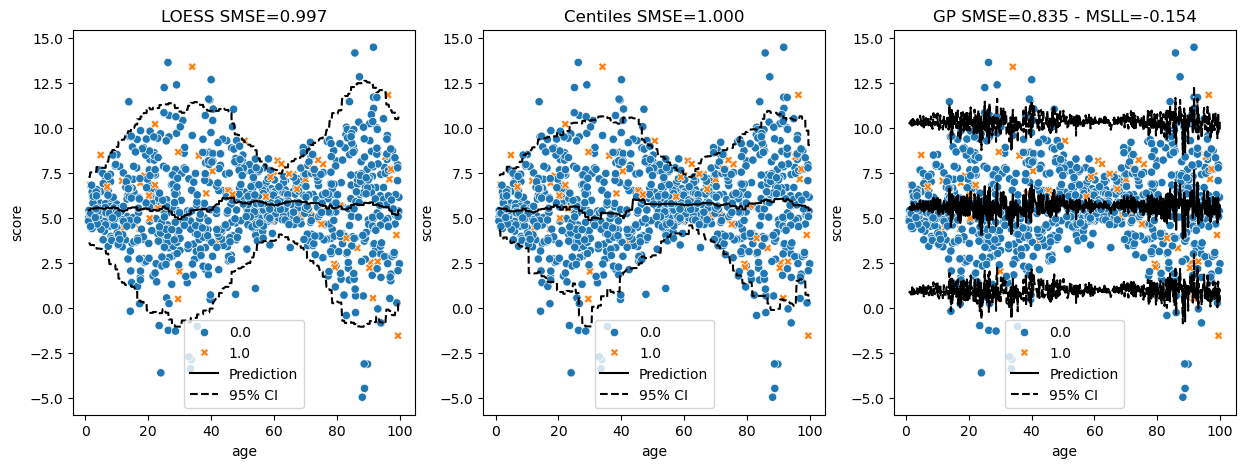

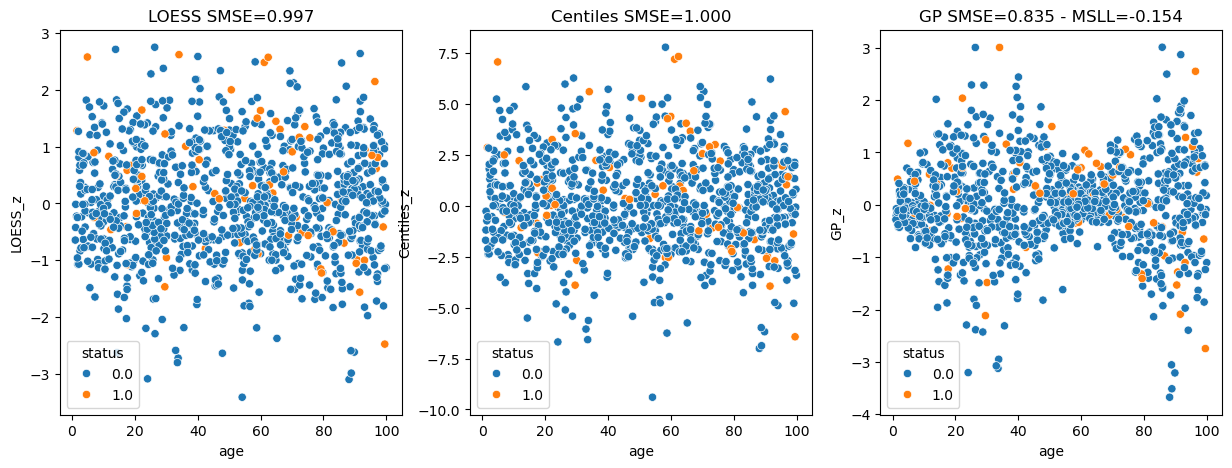

In [44]:
# Plot the data, model prediction and 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

### Fit GP model with fixed length_scale

The length scale in a Gaussian Process (GP) model is a key hyperparameter that plays a crucial role in defining the properties of the kernel function, which in turn influences how the GP model interprets the underlying function it is trying to learn. 

- The length scale determines how quickly the function values can change with respect to the input space. A larger length scale indicates that the function is expected to change slowly, leading to smoother variations. In contrast, a smaller length scale implies that the function can change rapidly, allowing for more fluctuations and sharp variations.

- In simpler terms, if the length scale is large, points that are far apart will have similar function values, indicating a smooth trend. Conversely, with a small length scale, points that are close together can have significantly different values.

- The length scale interacts with the kernel function, which defines the covariance structure of the Gaussian process. Common kernels, like the RBF kernel, utilize the length scale to compute similarities between input points:

$$
K(x_i, x_j) = \sigma^2 \exp\left(-\frac{||x_i - x_j||^2}{2 \cdot \text{length\_scale}^2}\right)
$$

- In this equation, $K(x_i,x_j)$ is the covariance between inputs $x_i$ and $x_j$, and $\sigma^2$ is the signal variance. The length scale directly influences how quickly the exponential decay occurs.



By default, the length_scale=1 is passed to the GP model and the underlying kernel, and the algorithm that fits the model does it's own hyperparameter tuning within the range of length_scale_bounds to find the length_scale it determines is best suited to the data. In this scenario, it has chosen a length_scale that is much too small, so we will pass a larger value and set length_scale_bounds to 'fixed' to prevent further hyperparameter tuning. Note: length_scale_bounds can be set to 'fixed' or a pair of floats >=0, the default bounds are (1e-5,1e5).

In [45]:
m_het.gp_normative_model(length_scale_bounds='fixed', length_scale=20)

/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:513: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:519: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")


Now that we've solved our first issue, we can see that the GP fails to accurately estimate the CI for the heteroskedastic data! This results in skewed deviance scores which we can see in the plot below. LOESS & Centiles succeed better in this scenario as they fit many local models (one in each bin) and don't need to assume homoskedasticity over the range of the data.

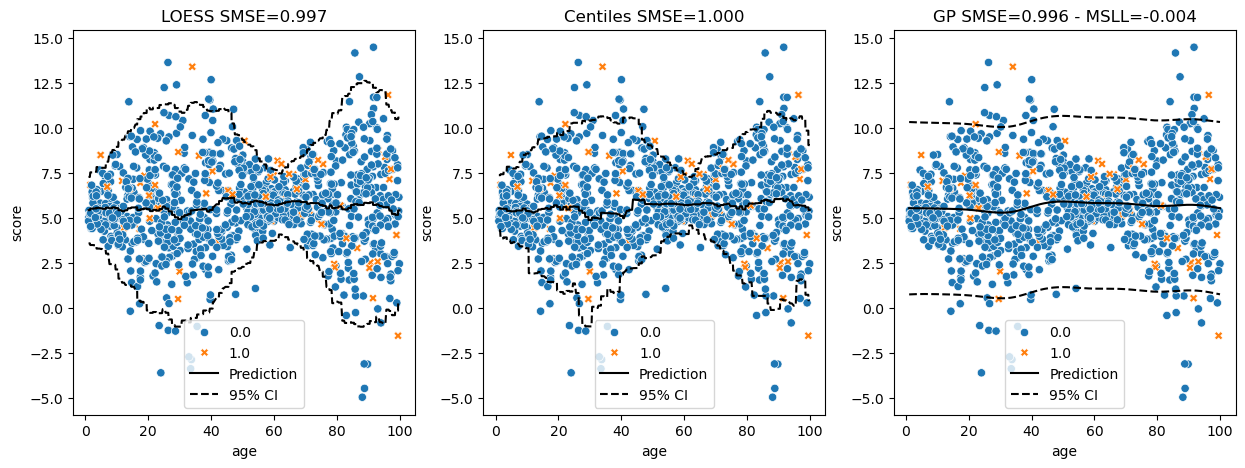

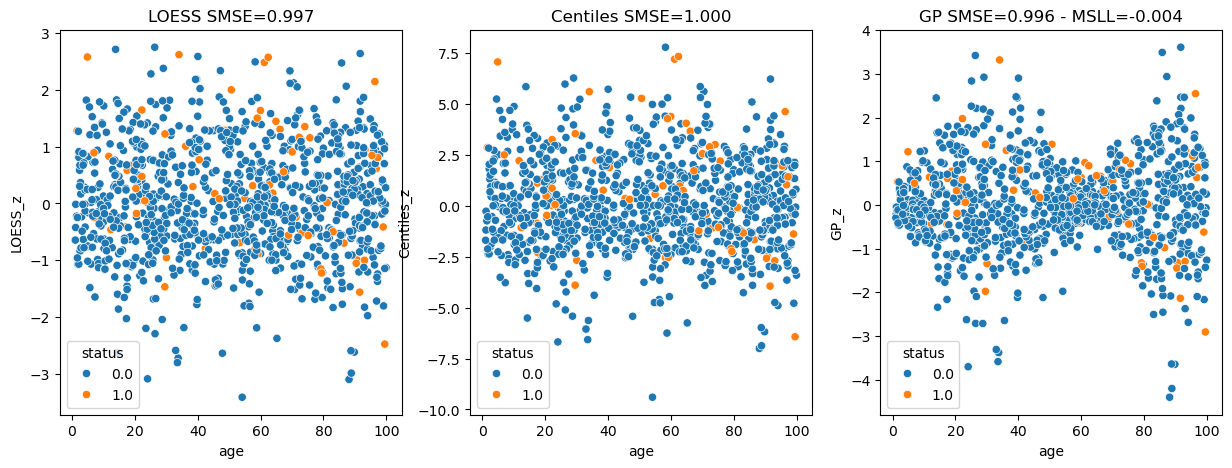

In [46]:
# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

## Full GP model outputs

We can explore the full outputs of the GP model by accessing the data attribute of the PyNM object. In general, all model outputs will be added as columns to the PyNM dataframe or as attributes to the PyNM object.

We won't look at the rest of the columns in data since they were covered in tutorial 1.



In [48]:
GP_cols = [col for col in m.data.columns if 'GP' in col]
m.data[GP_cols].head()

,GP_pred,GP_sigma,GP_residuals,GP_z
0,0.243982,0.119423,0.165038,1.381964
1,0.236600,0.119228,0.058007,0.486527
2,0.393704,0.118626,-0.080051,-0.674814
3,0.387562,0.120397,0.035613,0.295797
4,0.352835,0.118541,-0.095610,-0.806555


### Description of columns

- GP_pred
    - Prediction of the GP model (mean of predictive distribution)

- GP_sigma
    - Standard deviation of the GP model (std of predictive distribution)

- GP_residuals
    - Difference between the actual value of score and GP_pred

- GP_z
    - GP_residuals/GP_sigma

## Summary

- The GP model handles missing data well.
- The GP model can model an arbitrary number of confounds.
- Plotting the deviance scores for each of the categorical variables is a good check.
- Data must meet the GP model assumptions (notably homoskedasticity and gaussian noise) in order for the model to be reliable.
- We can use the length_scale and length_scale_bounds parameters of the GP model to adjust the model fit.


## Resources
- Kilian Weinberger's Cornell lecture
- A Visual Guide to Gaussian Processes on distill
- Sklearn's Gaussian Processes documentation
- Xu et al. PLoS ONE 2021, The pitfalls of using Gaussian Process Regression for normative modeling
